# Evaluation of multi-omics GRN inference methods
## Preprocessing multi-omics data
### by Jalil Nourisa

# Imports 

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix


import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import seaborn as sns
import json
import anndata as ad
import warnings
# import decoupler as dc

# from venn import venn 

import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})

work_dir = '../../output'
kaggle_data_dir = '/beegfs/desy/user/nourisaj/openproblems_sc_perturbation/input/'
# kaggle_data_dir = '../../input/kaggle/input'
T_cells = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
def func_leiden(adata):
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.tl.pca(adata, n_comps=50, use_highly_variable=True)
    sc.pp.neighbors(adata, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
def plot_umap(adata_o, color='leiden', ax=None, groups=None):
    adata = adata_o.copy()
    if groups is not None:
        adata.obs[color] = adata.obs[color].astype(str)
        mask = adata.obs[color].isin(groups)
        print(mask.sum())
        adata.obs.loc[~mask, color] = 'background'
    #     adata.obs['color'] = adata.obs['color'].astype(str).astype(categorical)
        
    x_data = adata.obsm['X_umap'][:,0]
    y_data = adata.obsm['X_umap'][:,1]
    xlim = [min(x_data)+.1*min(x_data), max(x_data)+.1*max(x_data)]
    ylim = [min(y_data)+.1*min(y_data), max(y_data)+.1*max(y_data)]
    if isinstance(adata.obs[color].iloc[0], (int, float)):
        # Continuous variable
        scatter = ax.scatter(x_data, y_data, c=adata.obs[color], cmap='viridis', alpha=0.3, s=1)
        plt.colorbar(scatter, ax=ax)
    else:
        unique_colors = adata.obs[color].unique()
        num_colors = len(unique_colors)
        if num_colors > 10:
            cmap = plt.get_cmap('tab20')  # Use a color map with more distinct colors
            color_list = cmap(np.linspace(0, 1, num_colors))
            color_list = [list(color_list[i]) for i in range(num_colors)]  # Convert each color to list format

        else:
            color_list = None  # Use default color map if fewer than 10 colors
            
        for i, c in enumerate(unique_colors):
            mask = adata.obs[color]==c
            if c == 'background':
                ax.scatter(x_data[mask], y_data[mask], s=.5, label=c, color='lightgrey', alpha=.01)
            else:
                ax.scatter(x_data[mask], y_data[mask], s=1, label=c, color=color_list[i] if color_list else None, alpha=.3)
            if color == 'leiden':
                avg_x = np.mean(x_data[mask])
                avg_y = np.mean(y_data[mask])
                ax.annotate(c, (avg_x, avg_y),ha='center', fontsize=15)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])

    if color!='leiden':
        legend = ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
        # legend = ax.legend()
        for handle in legend.legendHandles:
            handle.set_sizes([50])
    ax.set_title(color)
def plot_umap_group(adata, colors):
    n = len(colors)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 4))
    for ii, color in enumerate(colors):
        plot_umap(adata, color=color, ax=axes[ii])
    plt.tight_layout()
    return fig


In [3]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

# scRNA-seq
We use provided normalized values as X and store the counts in the layers.

## Formatize the data

In [4]:

genes_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Gene Expression']['location'].values
df_mrna = multiome_train[multiome_train['location'].isin(genes_locations)].reset_index(drop=True)
# get count and normalized count
df_mrna_pivot_raw = df_mrna.pivot(index='obs_id', columns='location', values='count')
df_mrna_pivot_raw = df_mrna_pivot_raw.fillna(0)
mrna_sparse_raw = csr_matrix(df_mrna_pivot_raw.values)
# df_mrna_pivot_n = df_mrna.pivot(index='obs_id', columns='location', values='normalized_count')
# df_mrna_pivot_n = df_mrna_pivot_n.fillna(0)
# mrna_sparse_n = csr_matrix(df_mrna_pivot_n.values)

In [7]:
adata_rna = ad.AnnData(X=mrna_sparse_raw, 
                obs=multiome_obs_meta.set_index('obs_id'),
                var=pd.DataFrame(index=df_mrna_pivot_raw.columns)
                )
adata_rna.shape

(25551, 22787)

## Merge cell types

In [9]:
# make it categorical
adata_rna.obs['cell_type'] = adata_rna.obs['cell_type'].astype('category')
# back up obs
adata_rna.obs['cell_type_original'] = adata_rna.obs['cell_type']
# agg cell type
adata_rna.obs.cell_type = adata_rna.obs.cell_type.apply(lambda name: 'T cells' if (name in T_cells) else name)

In [14]:
adata_rna.write(f'{work_dir}/scRNA/adata_rna.h5ad')

## QS

In [2]:
adata_rna = ad.read(f'{work_dir}/scRNA/adata_rna.h5ad')

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
import sctk
sctk.calculate_qc(adata_rna, flags={"mito": r"^MT-", "ribo": r"^RP[LS]"})
# sctk.calculate_qc(adata_rna)
sctk.cellwise_qc(adata_rna)

/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


n_counts: [1000.0000463230983, 19978.994140625], 25547/25547 passed
n_genes: [691.1768837674327, 5745.001953125], 25429/25547 passed
percent_mito: [0.0, 15.571746011893392], 25402/25547 passed
percent_ribo: [0.8829415259221228, 16.21716400235061], 25201/25547 passed
25034/25547 pass


In [8]:
25547 - 25034

513

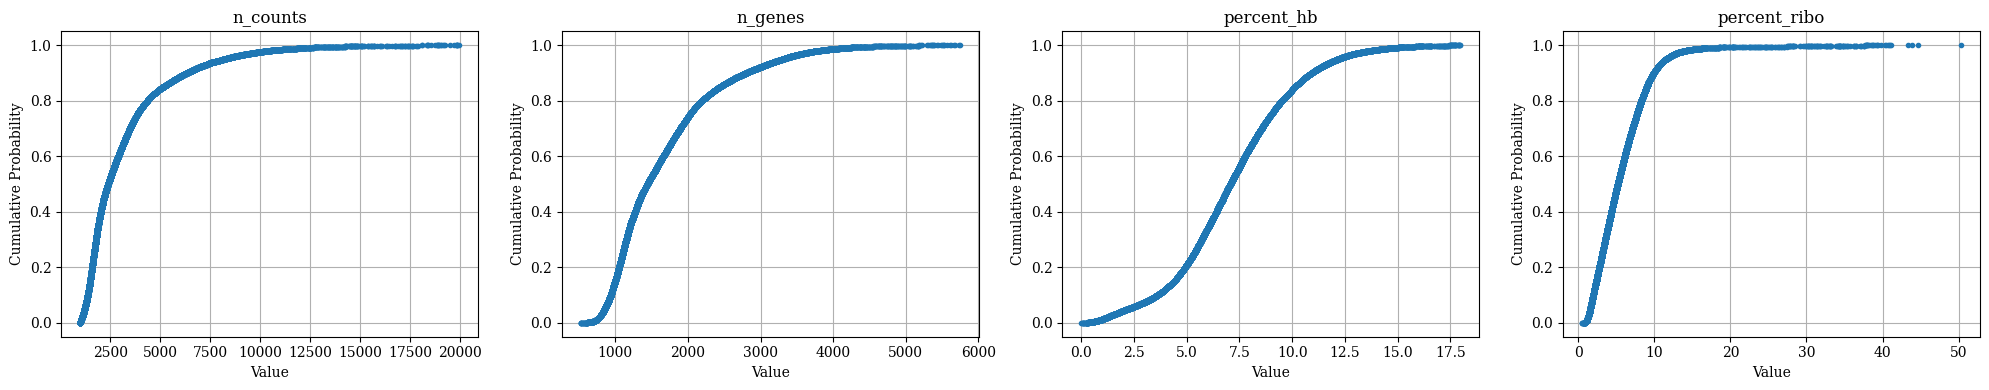

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))
def plot_CDF(data, title, ax):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True)

plot_CDF(adata_rna.obs.n_counts, 'n_counts', axes[0])
plot_CDF(adata_rna.obs.n_genes, 'n_genes', axes[1])
plot_CDF(adata_rna.obs.percent_mito, 'percent_hb', axes[2])
plot_CDF(adata_rna.obs.percent_ribo, 'percent_ribo', axes[3])
plt.tight_layout()
plt.show()

In [13]:
# apply filtering: cell weise 
adata_rna = adata_rna[adata_rna.obs.cell_passed_qc]

In [17]:
(adata_rna.X!=0).sum(axis=1).min()

692

## Save

In [25]:
adata_rna.obs = adata_rna.obs.drop(columns=['n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_top50', 'cell_passed_qc'])
adata_rna.var = adata_rna.var.drop(columns=['mito', 'ribo', 'n_counts', 'n_cells'])
del adata_rna.uns

map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
adata_rna.obs['Donor'] = adata_rna.obs.donor_id.map(map_names)
adata_rna.obs['Cell type'] = adata_rna.obs.cell_type

adata_rna.write(f'{work_dir}/scRNA/adata_rna.h5ad')

## Normalization and clustering

In [39]:
adata_rna = ad.read(f'{work_dir}/scRNA/adata_rna.h5ad')

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [178]:
adata_rna_donor_1 = adata_rna[adata_rna.obs.donor_id=='donor_0', :]
adata_rna_donor_2 = adata_rna[adata_rna.obs.donor_id=='donor_1', :]
adata_rna_donor_3 = adata_rna[adata_rna.obs.donor_id=='donor_2', :]

In [180]:
func_leiden(adata_rna_donor_1)
func_leiden(adata_rna_donor_2)
# func_leiden(adata_rna_donor_3)

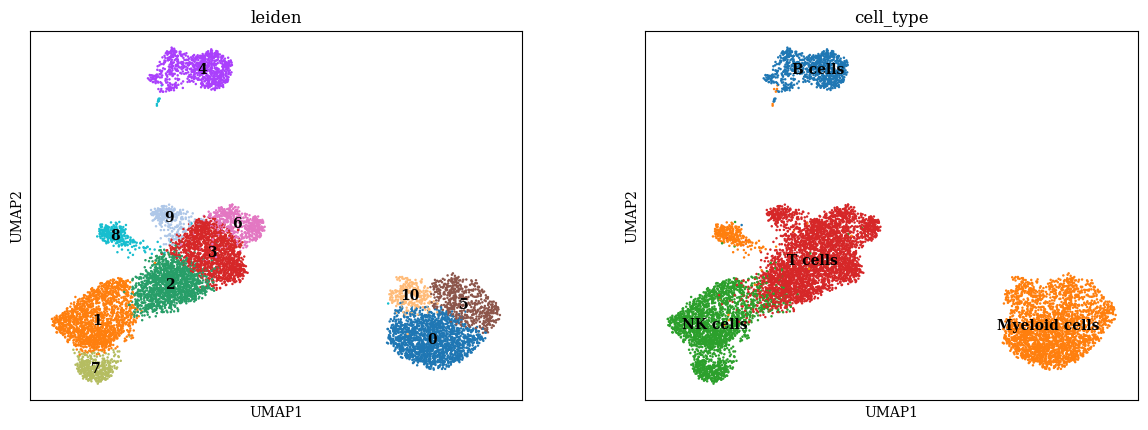

In [48]:
sc.pl.umap(
    adata_rna_donor_3,
    color=["leiden", "cell_type"],
    legend_loc="on data"
)

## Cell type annotation

In [165]:
from celltypist import models
import celltypist
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

def cell_typist(adata, model, meta):
    adata_celltypist = adata.copy()
    adata_celltypist.X = adata_celltypist.layers['counts']

    del adata_celltypist.obsp
    del adata_celltypist.uns
    del adata_celltypist.varm
    
    sc.pp.normalize_per_cell(
        adata_celltypist, counts_per_cell_after=10**4
    ) 
    sc.pp.log1p(adata_celltypist) 
    adata_celltypist.X = adata_celltypist.X.toarray()
    
    predictions = celltypist.annotate(
        adata_celltypist, model=model, majority_voting=True
    )
    
    predictions_adata = predictions.to_adata()

    adata.obs[f'cell_type_celltypist_{meta}'] = predictions_adata.obs.majority_voting
    adata.obs[f'conf_score_celltypist_{meta}'] = predictions_adata.obs.conf_score

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json


📚 Total models in list: 47
📂 Storing models in /root/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [149]:
# model_high.cell_types
# model_low.cell_types

In [166]:
cell_type_mapping = {
    'B cells': 'B cells',
    'B-cell lineage': 'B cells',
    'Cycling cells': None,  # Not mapped to a specific category
    'DC': 'Myeloid cells',
    'DC precursor': 'Myeloid cells',
    'Double-negative thymocytes': 'T cells',
    'Double-positive thymocytes': 'T cells',
    'ETP': 'T cells',
    'Early MK': None,  # Not mapped to a specific category
    'Endothelial cells': None,  # Not mapped to a specific category
    'Epithelial cells': None,  # Not mapped to a specific category
    'Erythrocytes': None,  # Not mapped to a specific category
    'Erythroid': None,  # Not mapped to a specific category
    'Fibroblasts': None,  # Not mapped to a specific category
    'Granulocytes': 'Myeloid cells',
    'HSC/MPP': 'Myeloid cells',
    'ILC': 'NK cells',
    'ILC precursor': 'NK cells',
    'MNP': 'Myeloid cells',
    'Macrophages': 'Myeloid cells',
    'Mast cells': None,  # Not mapped to a specific category
    'Megakaryocyte precursor': None,  # Not mapped to a specific category
    'Megakaryocytes/platelets': None,  # Not mapped to a specific category
    'Mono-mac': 'Myeloid cells',
    'Monocyte precursor': 'Myeloid cells',
    'Monocytes': 'Myeloid cells',
    'Myelocytes': 'Myeloid cells',
    'Plasma cells': 'B cells',
    'Promyelocytes': 'Myeloid cells',
    'T cells': 'T cells',
    'pDC': 'Myeloid cells',
    'pDC precursor': 'Myeloid cells'
}
# cell_type_mapping = {
#     'Age-associated B cells': 'B cells',
#     'Alveolar macrophages': 'Myeloid cells',
#     'CD16+ NK cells': 'NK cells',
#     'Classical monocytes': 'Myeloid cells',
#     'DC2': 'Myeloid cells',
#     'Megakaryocyte precursor': None,  # Not mapped to a specific category
#     'Memory B cells': 'B cells',
#     'Naive B cells': 'B cells',
#     'Non-classical monocytes': 'Myeloid cells',
#     'Plasma cells': 'B cells',
#     'Regulatory T cells': 'T cells',
#     'Tcm/Naive helper T cells': 'T cells',
#     'Tem/Temra cytotoxic T cells': 'T cells',
#     'Tem/Trm cytotoxic T cells': 'T cells'
# }



In [182]:
cell_typist(adata_rna_donor_2, model_high, meta='coarse')   

🔬 Input data has 7895 cells and 22778 genes
🔗 Matching reference genes in the model
🧬 5540 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [169]:
# adata_rna_donor_3.obs['cell_type_mapped'] = adata_rna_donor_3.obs['cell_type_celltypist_coarse'].map(cell_type_mapping) 
# adata_rna_donor_3.obs['cell_type_mapped'].unique()
# print(np.sort(adata_rna_donor_3.obs['cell_type_celltypist_coarse'].unique()))
# np.intersect1d(list(cell_type_mapping.keys()), adata_rna_donor_3.obs['cell_type_celltypist_coarse'].unique())

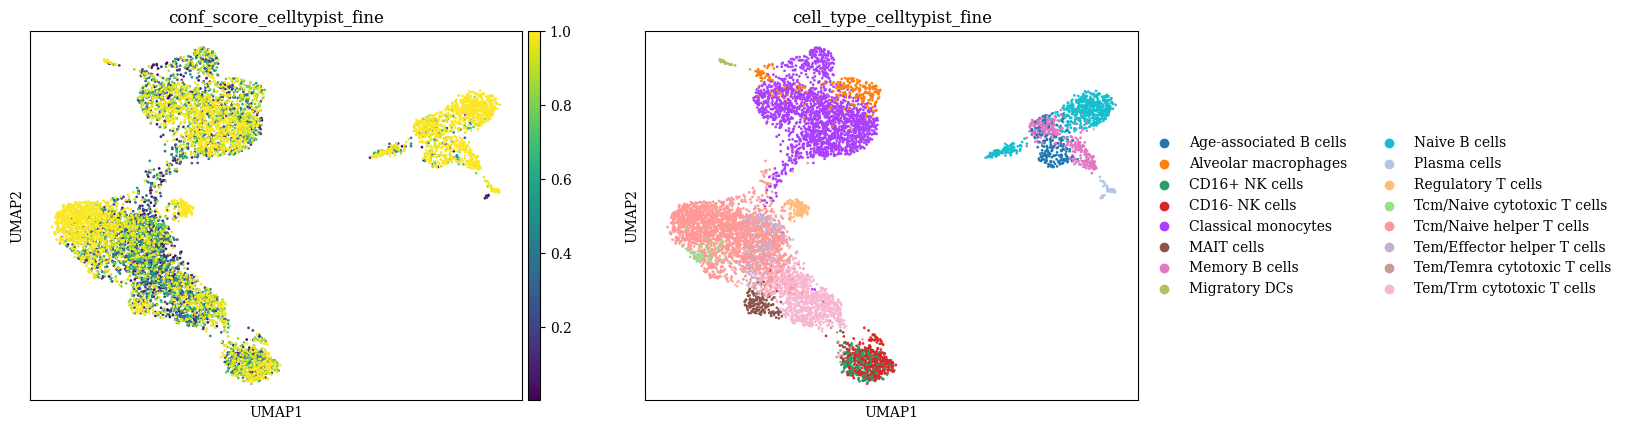

<function __main__.plot_umap(adata_o, color='leiden', ax=None, groups=None)>

: 

In [186]:

sc.pl.umap(
    adata_rna_donor_2,
    # color=["cell_type", "conf_score_celltypist_coarse", "cell_type_celltypist_coarse"],
    color=["conf_score_celltypist_fine", "cell_type_celltypist_fine"],

    # legend_loc='on data' 
)
plot_umap


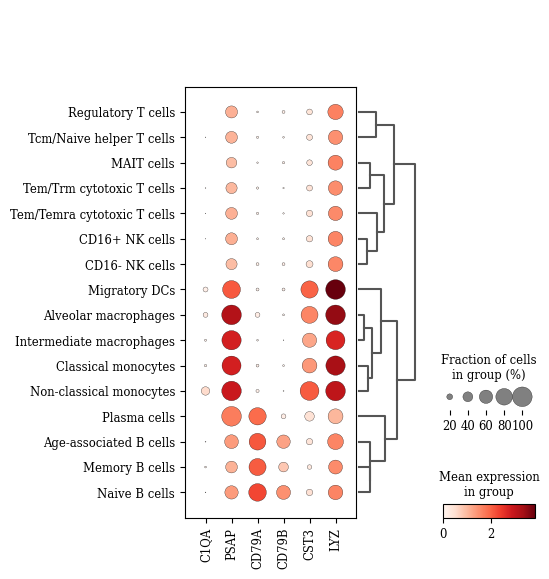

In [122]:
# sc.pl.dendrogram(predictions_adata, groupby="majority_voting")
markers = ['C1QA', 'PSAP', 'CD79A', 'CD79B', 'CST3', 'LYZ']
sc.pl.dotplot(predictions_adata, markers, groupby='majority_voting', dendrogram=True)

In [92]:
import decoupler as dc
pbmc_markers = pd.read_csv(f"{work_dir}/../output/decoupler_final_labels.csv")

def run_dc(adata, labels, resolution, meta_name):
    
    adata = adata.copy()
    ## Run ORA:
    dc.run_ora(
    mat=adata,
    net=labels,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
    )
    
    acts = dc.get_acts(adata, obsm_key='ora_estimate')
    # We need to remove inf and set them to the maximum value observed
    acts_v = acts.X.ravel()
    max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
    acts.X[~np.isfinite(acts.X)] = max_e

    # We can scale the obtained activities for better visualizations
    sc.pp.scale(acts)
    
    df = dc.rank_sources_groups(acts, groupby='leiden_'+str(resolution), reference='rest', method='wilcoxon')
    
    n_ctypes = 3
    ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
    
    annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
    adata.obs[str(meta_name)] = [annotation_dict[clust] for clust in adata.obs['leiden_'+str(resolution)]]
    
    return adata


### Annotation using decoupler and markers

In [96]:
adata = adata_rna_donor_3.copy()
    ## Run ORA:
dc.run_ora(
    mat=adata,
    net=pbmc_markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
    )
    
acts = dc.get_acts(adata, obsm_key='ora_estimate')

25 features of mat are empty, they will be removed.
Running ora on mat with 9432 samples and 22753 targets for 6 sources.


100%|██████████| 9432/9432 [00:13<00:00, 676.32it/s] 


In [107]:
adata

AnnData object with n_obs × n_vars = 9432 × 22778
    obs: 'cell_type', 'donor_id', 'cell_type_original', 'Donor', 'Cell type', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'cell_type_original_colors', 'cell_type_colors'
    obsm: 'ora_estimate', 'ora_pvals', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

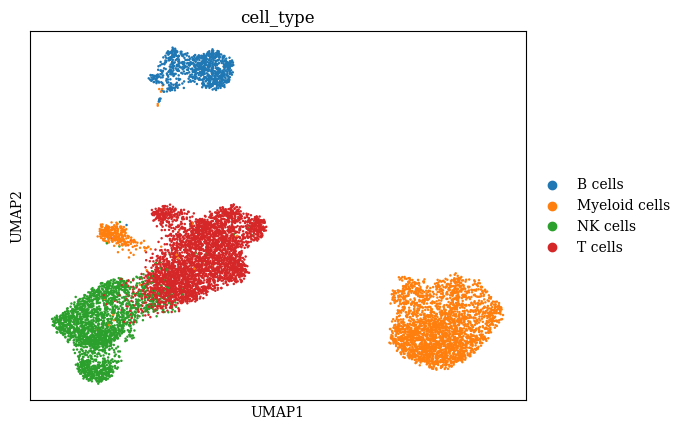

In [106]:
# func_leiden(adata)
sc.pl.umap(
    adata,
    color=["cell_type"],
    # legend_loc='on data' 
)

In [58]:
predictions_high_adata.obs.majority_voting.unique()

['T cells', 'ILC', 'Macrophages', 'B cells', 'Monocytes', 'DC', 'Plasma cells']
Categories (7, object): ['B cells', 'DC', 'ILC', 'Macrophages', 'Monocytes', 'Plasma cells', 'T cells']

In [45]:

def plot_umap(adata_o, color='leiden', ax=None, groups=None):
    adata = adata_o.copy()
    if groups is not None:
        adata.obs[color] = adata.obs[color].astype(str)
        mask = adata.obs[color].isin(groups)
        print(mask.sum())
        adata.obs.loc[~mask, color] = 'background'
    #     adata.obs['color'] = adata.obs['color'].astype(str).astype(categorical)
        
    x_data = adata.obsm['X_umap'][:,0]
    y_data = adata.obsm['X_umap'][:,1]
    xlim = [min(x_data)+.1*min(x_data), max(x_data)+.1*max(x_data)]
    ylim = [min(y_data)+.1*min(y_data), max(y_data)+.1*max(y_data)]
    unique_colors = adata.obs[color].unique()
    unique_colors = sorted(adata.obs[color].unique())  # Sort unique colors alphabetically
    for c in unique_colors:
        mask = adata.obs[color]==c
        if c=='background':
            ax.scatter(x_data[mask], y_data[mask], s=.5, label=c, color='lightgrey', alpha=.01)
        else:
            ax.scatter(x_data[mask], y_data[mask], s=1, label=c, alpha=.3)
        if color == 'leiden':
            avg_x = np.mean(x_data[mask])
            avg_y = np.mean(y_data[mask])
            ax.annotate(c, (avg_x, avg_y),ha='center', fontsize=15)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])

    if color!='leiden':
        legend = ax.legend(loc='upper left', bbox_to_anchor=(1,.5))
        # legend = ax.legend()
        for handle in legend.legendHandles:
            handle.set_sizes([100])
    ax.set_title(color)
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# plot_umap(adata_rna_c, color='leiden', ax=axes[0], groups=None)
# plot_umap(adata_rna_c, color='cell_type', ax=axes[1], groups=None)


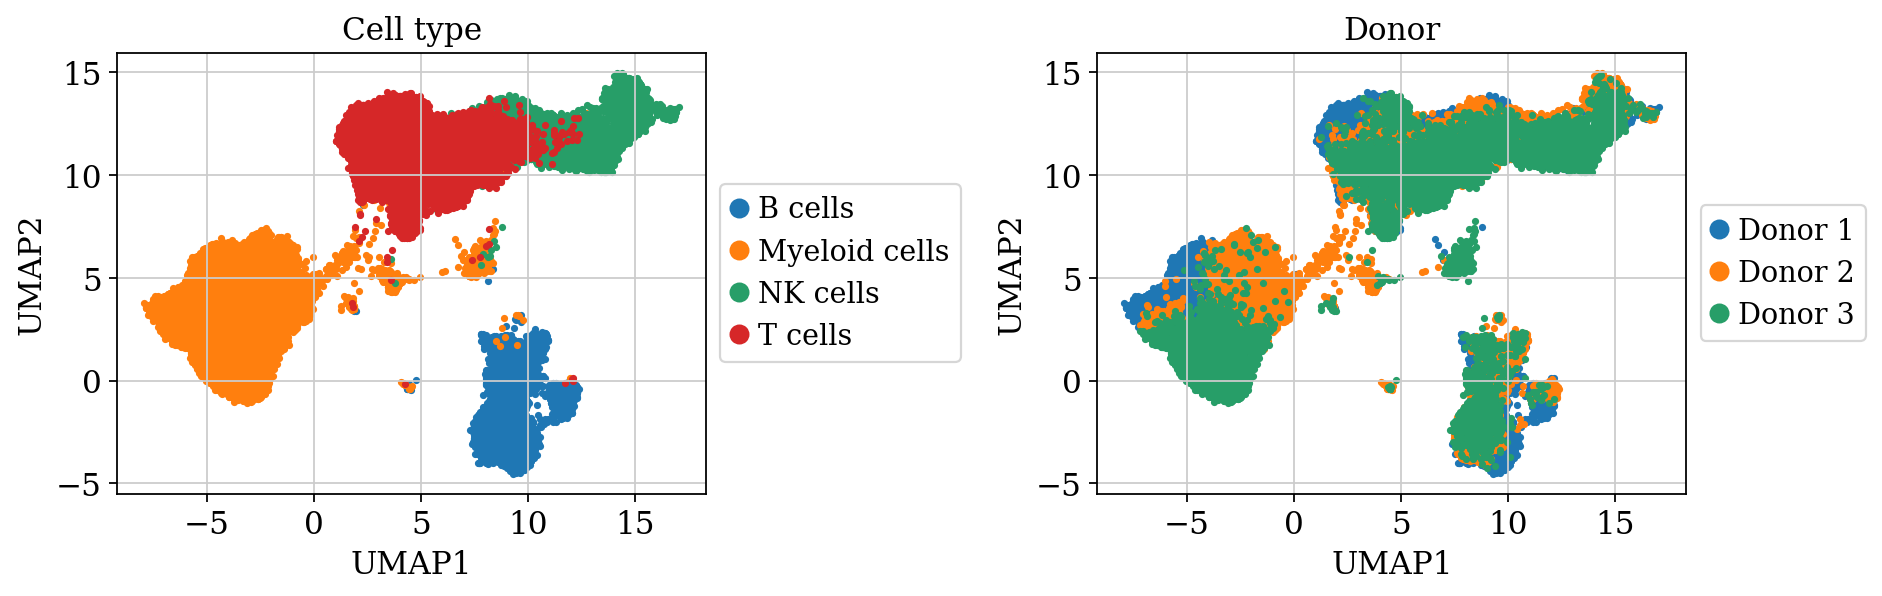

In [28]:


# fig.savefig(f'{work_dir}/preprocess/figs/rna_cluster.png', dpi=300)
plt.show()


As can be seen, the cell types of B cells and Myeloid cells are clearly seperated while there is more overlap between other cell types. We can also see the under represenation of T cells CD8+ and T regulatory cells. These two cell types are somewhat blended with T cells CD4+. We dont see any clear seggregation for donor_id.

In [31]:
adata_rna.layers['x_norm'] = adata_rna.X
adata_rna.X = adata_rna.layers['counts']

In [33]:
adata_rna.X.data

array([1., 1., 1., ..., 2., 1., 1.])

In [34]:
adata_rna.write(f'{work_dir}/scRNA/adata_rna.h5ad')

In [ ]:
aa

# scATAC-seq

## Formatize the data

In [35]:
# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
# del multiome_train

# make adata for each donor and save
def extract_count(count='count'):
    df_peaks_table = df_peaks.pivot_table(index='obs_id', columns='location', values=count)
    df_peaks_table.fillna(0, inplace=True)
    print('df_peaks table created')
    return df_peaks_table
df_peaks_table = extract_count(count='count')
# create adata
X = csr_matrix(df_peaks_table.values)
locations = df_peaks_table.columns
obs_ids = df_peaks_table.index
cell_types = []
for cell in obs_ids:
    cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])




df_peaks table created


NameError: name 'anndata' is not defined

In [36]:
obs = pd.DataFrame(index=obs_ids)
obs['cell_type'] = cell_types
var = pd.DataFrame(index=locations)
adata_atac = ad.AnnData(X=X, obs=obs, var=var)
print('adata is created')

adata is created


In [37]:
split = adata_atac.var_names.str.split(r"[:-]")
adata_atac.var["chrom"] = split.map(lambda x: x[0]).astype(str)
adata_atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
adata_atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
adata_atac.var.head()

,chrom,chromStart,chromEnd
location,,,
GL000194.1:100992-101876,GL000194.1,100992,101876
GL000194.1:104344-105163,GL000194.1,104344,105163
GL000194.1:110741-111545,GL000194.1,110741,111545
GL000194.1:114513-115368,GL000194.1,114513,115368
GL000194.1:27939-28826,GL000194.1,27939,28826


In [38]:
mask_standard_dna = adata_atac.var['chrom'].str.match(r'^chr(?:\d+|X|Y)$')
adata_atac = adata_atac[:,mask_standard_dna]

In [39]:
# add donor info
adata_atac.obs = pd.merge(adata_atac.obs, multiome_obs_meta[['obs_id', 'donor_id']], on='obs_id', how='left')


In [43]:
# save
adata_atac.write(f'{work_dir}/scATAC/adata_atac.h5ad')

## Merge cell type

In [2]:
adata_atac = ad.read(f'{work_dir}/scATAC/adata_atac.h5ad')

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [58]:
# adata_atac.obs.set_index('obs_id',inplace=True)

In [40]:
# make it categorical
adata_atac.obs['cell_type'] = adata_atac.obs['cell_type'].astype('category')
# back up obs
adata_atac.obs['cell_type_original'] = adata_atac.obs['cell_type']
# T cells
adata_atac.obs.cell_type = adata_atac.obs.cell_type.apply(lambda name: 'T cells' if (name in T_cells) else name)

In [41]:
map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
adata_atac.obs['Donor'] = adata_atac.obs.donor_id.map(map_names)
adata_atac.obs['Cell type'] = adata_atac.obs.cell_type

In [42]:
adata_atac.X.data

array([2., 2., 4., ..., 3., 2., 2.])

## UMAP plot using scATAC-seq


In [66]:
adata_atac.layers['counts'] = adata_atac.X.copy()

In [70]:
adata_atac.layers['counts'].data

array([2., 2., 4., ..., 3., 2., 2.])

In [71]:
# import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    sc.pp.normalize_total(adata_atac)
    sc.pp.log1p(adata_atac)
    sc.pp.highly_variable_genes(adata_atac, n_top_genes=3000)
    sc.tl.pca(adata_atac, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(adata_atac, n_neighbors=10, n_pcs=50)
    sc.tl.umap(adata_atac)
adata_atac

AnnData object with n_obs × n_vars = 25551 × 135418
    obs: 'cell_type', 'donor_id', 'cell_type_original', 'Donor', 'Cell type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

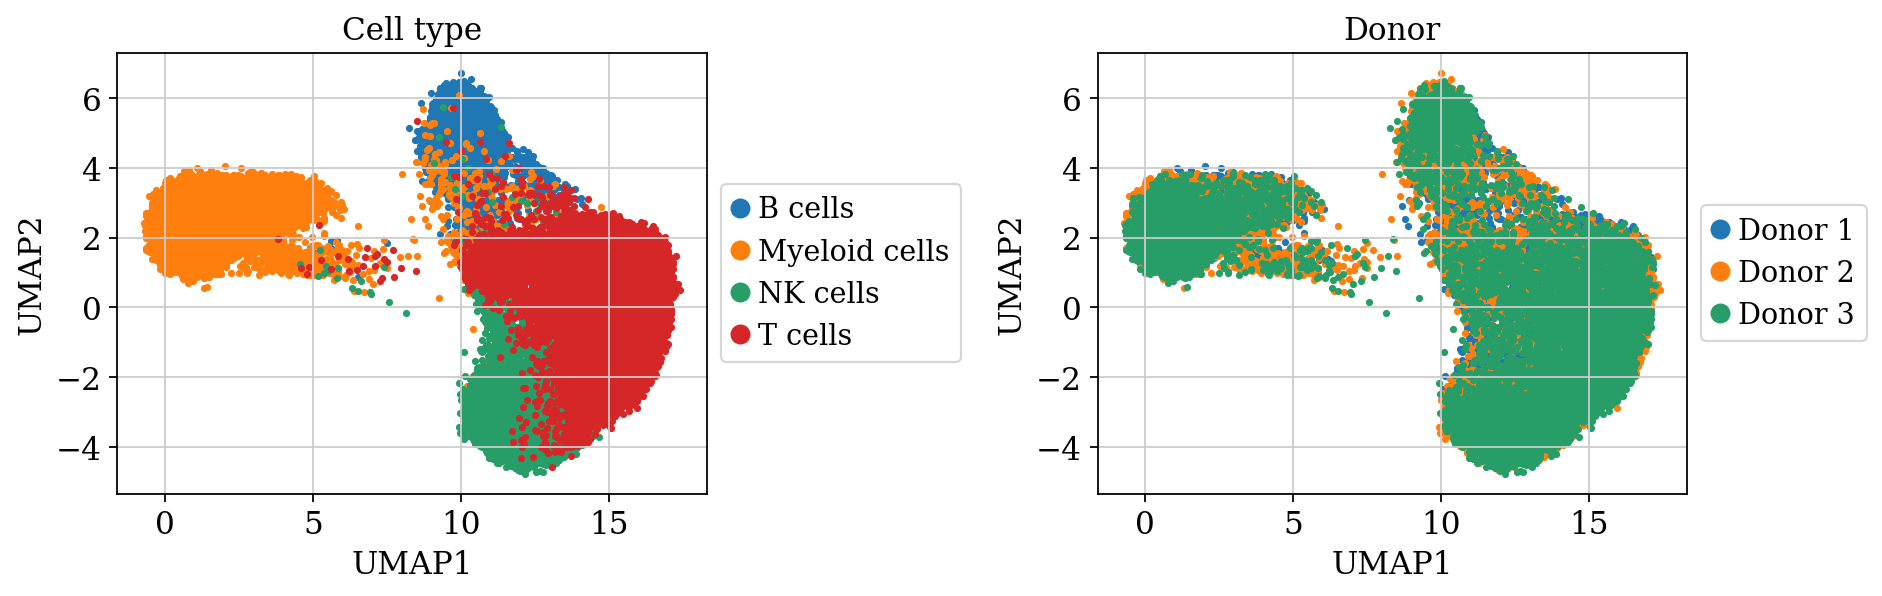

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

def cluster_plot(adata, var, ax):
    dim_data = adata.obsm['X_umap']
    legend_handles = []  
    var_unique = sorted(adata.obs[var].unique())  
    var_unique_sorted = sorted(var_unique)  
    for sub_var in var_unique_sorted:
        mask = adata.obs[var] == sub_var
        sub_data = dim_data[mask]
        scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=sub_var, s=5)
        legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))

    ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(var)

for i_ax, var in enumerate(['Cell type', 'Donor']): 
    cluster_plot(adata_atac, var, axes[i_ax])

plt.tight_layout()

# fig.savefig(f'{work_dir}/preprocess/figs/atac_cluster.png', dpi=300)
plt.show()


In [73]:
# adata_atac.layers['x_norm'] = adata_atac.X
adata_atac.X = adata_atac.layers['counts']
adata_atac.layers['counts'].data


array([2., 2., 4., ..., 3., 2., 2.])

In [11]:
# save
adata_atac.write(f'{work_dir}/scATAC/adata_atac.h5ad')